In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV3Large
from keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow_addons as tfa
from tensorflow.keras import mixed_precision

# 데이터셋 로더

In [3]:
# **1. GPU 메모리 성장 설정 (가장 먼저 실행)**
physical_devices = tf.config.list_physical_devices('GPU')
for gpu in physical_devices:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
        print(f"메모리 성장 설정 완료: {gpu}")
    except RuntimeError as e:
        print(f"메모리 성장 설정 실패: {gpu} - {e}")

# **2. 분산 전략 설정**
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# **3. 데이터셋 로더 함수**
def load_data(csv_file, image_dir):
    df = pd.read_csv(csv_file)
    image_paths = df['image_path'].tolist()
    keypoints = df.iloc[:, 1:].values.astype(np.float32)  # [x1, y1, x2, y2, ..., x70, y70]
    return image_paths, keypoints

# **4. 데이터 증강 함수 정의 (회전 및 줌인/아웃)**
def augment(image, keypoints, target_size=224):
    NUM_KEYPOINTS = 70  # 70개의 키포인트

    # 랜덤 회전 (-15도 ~ 15도)
    angle = tf.random.uniform([], -15, 15, dtype=tf.float32)
    angle_rad = angle * np.pi / 180.0
    image = tfa.image.rotate(image, angles=angle_rad, fill_mode='nearest')

    # 키포인트 회전
    center = tf.constant([target_size / 2.0, target_size / 2.0], dtype=tf.float32)
    keypoints = tf.reshape(keypoints, [NUM_KEYPOINTS, 2])  # [70, 2]
    rotation_matrix = tf.reshape([
        tf.cos(angle_rad), -tf.sin(angle_rad),
        tf.sin(angle_rad), tf.cos(angle_rad)
    ], [2, 2])
    keypoints = tf.matmul(keypoints - center, rotation_matrix) + center

    # 랜덤 줌인/아웃 (0.9 ~ 1.1 배)
    zoom_factor = tf.random.uniform([], 0.9, 1.1, dtype=tf.float32)

    # 이미지 크기 변경
    new_size = tf.cast(target_size * zoom_factor, tf.int32)
    image = tf.image.resize(image, [new_size, new_size])

    # 중앙에서 크롭 또는 패딩
    image = tf.image.resize_with_crop_or_pad(image, target_size, target_size)

    # 줌에 따른 키포인트 조정
    padding = tf.cast(target_size - new_size, tf.float32) / 2.0
    keypoints = keypoints * zoom_factor + padding

    # 키포인트 재정렬
    keypoints = tf.reshape(keypoints, [-1])  # [x1, y1, x2, y2, ..., x70, y70]

    # 키포인트 정규화
    keypoints_normalized = keypoints / tf.cast(target_size, tf.float32)

    # 키포인트가 [0,1] 범위 내에 있는지 확인
    condition_x = tf.reduce_all(tf.logical_and(keypoints_normalized[::2] >= 0.0, keypoints_normalized[::2] <= 1.0))
    condition_y = tf.reduce_all(tf.logical_and(keypoints_normalized[1::2] >= 0.0, keypoints_normalized[1::2] <= 1.0))
    is_valid = tf.logical_and(condition_x, condition_y)

    return image, keypoints_normalized, is_valid


# **5. 이미지 및 키포인트 전처리 함수 (종횡비 유지 및 패딩 추가)**
def preprocess_image(image_path, keypoints, image_dir, target_size=224, original_width=720, original_height=1280):
    # 이미지 경로 결합
    image_full_path = tf.strings.join([image_dir, '/', image_path])

    # 이미지 로드 및 디코드
    image = tf.io.read_file(image_full_path)
    image = tf.image.decode_jpeg(image, channels=3)

    # 이미지가 정상적으로 로드되었는지 확인하고, float32로 변환 및 [0,1] 범위로 스케일링
    image = tf.cond(tf.equal(tf.size(image), 0),
                   lambda: tf.zeros([target_size, target_size, 3], dtype=tf.float32),
                   lambda: tf.image.convert_image_dtype(image, tf.float32))

    # 원본 크기 가져오기
    orig_shape = tf.shape(image)[:2]
    orig_height_img = tf.cast(orig_shape[0], tf.float32)
    orig_width_img = tf.cast(orig_shape[1], tf.float32)

    # 종횡비 유지하며 리사이징
    scale = tf.minimum(target_size / orig_width_img, target_size / orig_height_img)
    new_width = tf.cast(tf.round(orig_width_img * scale), tf.int32)
    new_height = tf.cast(tf.round(orig_height_img * scale), tf.int32)

    image = tf.image.resize(image, [new_height, new_width])

    # 패딩 추가하여 타겟 사이즈 맞추기
    pad_width = target_size - new_width
    pad_height = target_size - new_height
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top

    image = tf.pad(image, [[pad_top, pad_bottom], [pad_left, pad_right], [0, 0]], constant_values=0)

    # 키포인트 스케일 조정 및 이동 (Pixel space, not normalized)
    keypoints = tf.convert_to_tensor(keypoints, dtype=tf.float32)
    x_coords = keypoints[0:140:2]  # x1~x70
    y_coords = keypoints[1:140:2]  # y1~y70

    # 스케일링 및 이동
    x_scale = scale
    y_scale = scale

    x_scaled = x_coords * x_scale + tf.cast(pad_left, tf.float32)
    y_scaled = y_coords * y_scale + tf.cast(pad_top, tf.float32)

    scaled_keypoints = tf.stack([x_scaled, y_scaled], axis=1)  # [70, 2]
    scaled_keypoints = tf.reshape(scaled_keypoints, [-1])  # [x1, y1, x2, y2, ..., x70, y70]

    return image, scaled_keypoints  # 정규화된 키포인트가 아닌 픽셀 좌표 반환

# **6. 키포인트 정규화 함수**
def normalize_keypoints(image, keypoints, target_size=224):
    keypoints_normalized = keypoints / tf.cast(target_size, tf.float32)
    return image, keypoints_normalized

# **7. 데이터셋 전처리 및 증강 함수**
def preprocess_image_aug(image_path, keypoints, image_dir, target_size=224, original_width=720, original_height=1280):
    image, keypoints = preprocess_image(image_path, keypoints, image_dir, target_size, original_width, original_height)
    image_original, keypoints_original = image, keypoints  # 원본 이미지와 키포인트 저장

    # 증강 시도
    image_aug, keypoints_aug, is_valid = augment(image, keypoints, target_size)

    # 증강 성공 시 증강된 이미지와 키포인트, 실패 시 원본 이미지와 키포인트 반환
    image_final = tf.cond(is_valid, lambda: image_aug, lambda: image_original)
    keypoints_final = tf.cond(is_valid, lambda: keypoints_aug, lambda: keypoints_original)  # 이미 정규화됨

    return image_final, keypoints_final, is_valid  # 추가 정규화 제거

# **8. 데이터셋 생성 함수 수정**
def create_dataset(image_paths, keypoints, image_dir, batch_size=64, shuffle=True, augment_data=False, target_size=224, original_width=720, original_height=1280):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, keypoints))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths))

    # image_dir을 TensorFlow 상수로 변환
    image_dir_tf = tf.constant(image_dir)

    if augment_data:
        # 데이터 증강 적용
        dataset = dataset.map(
            lambda x, y: preprocess_image_aug(x, y, image_dir_tf, target_size, original_width, original_height),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        # Augment 함수에서 반환하는 is_valid 유지
        # is_valid가 True인 경우만 포함
        dataset = dataset.filter(lambda image, keypoints, is_valid: is_valid)
        # (image, keypoints, is_valid) -> (image, keypoints)
        dataset = dataset.map(lambda image, keypoints, is_valid: (image, keypoints))
    else:
        # 데이터 증강 미적용
        dataset = dataset.map(
            lambda x, y: preprocess_image(x, y, image_dir_tf, target_size, original_width, original_height),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        # **변경 사항**: 키포인트 정규화 추가
        dataset = dataset.map(
            lambda image, keypoints: normalize_keypoints(image, keypoints, target_size),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# **9. 데이터셋 합치기 함수**
def combine_datasets(original_dataset, augmented_dataset):
    combined_dataset = original_dataset.concatenate(augmented_dataset)
    return combined_dataset

메모리 성장 설정 완료: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
메모리 성장 설정 완료: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
메모리 성장 설정 완료: PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
Number of devices: 3


2024-11-14 01:05:06.338153: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-14 01:05:06.342124: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-14 01:05:06.346048: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

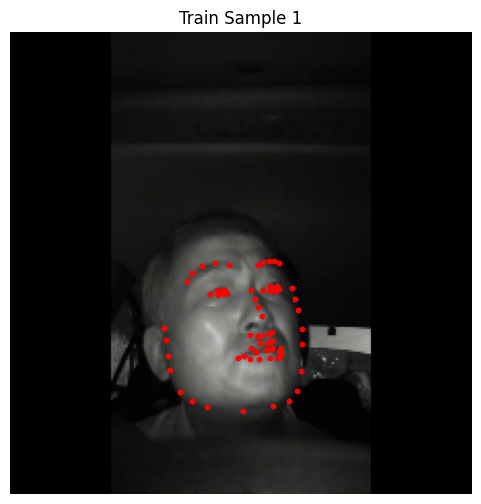

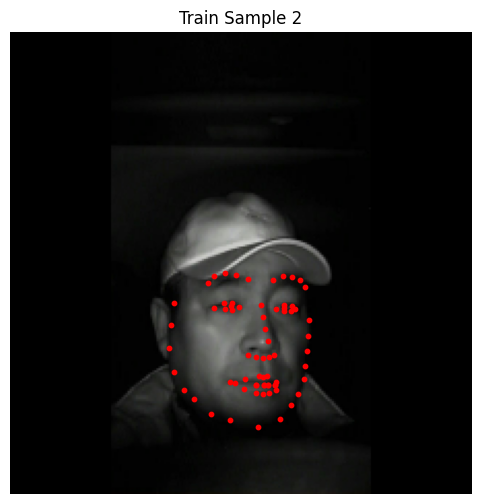

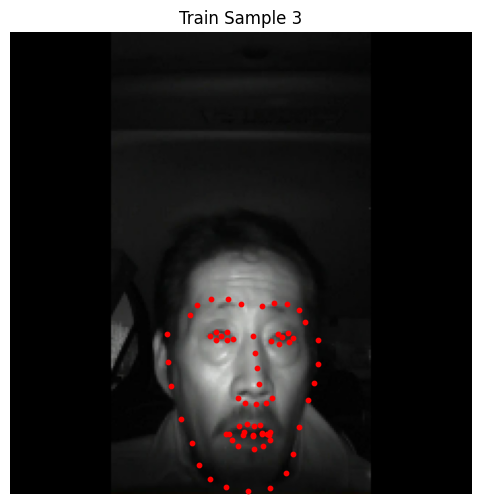

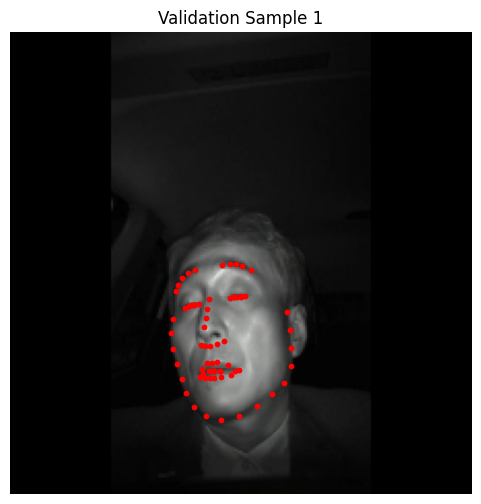

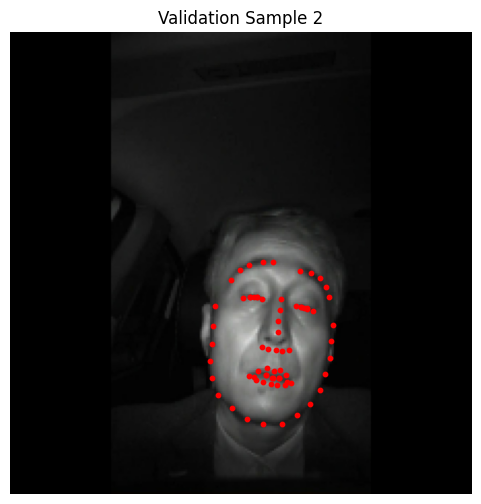

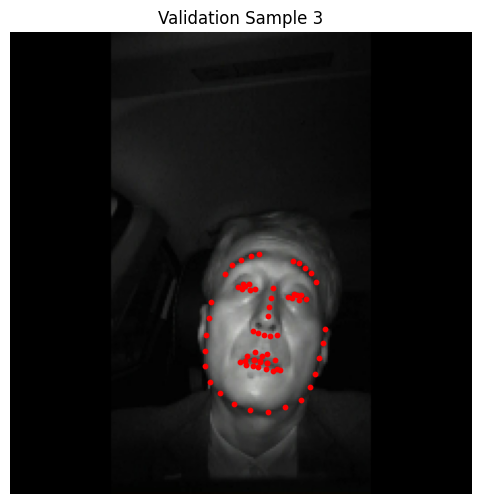

In [4]:
# **CSV 파일 경로**
train_csv = 'keras_dataset/annotations/train_annotations.csv'
val_csv = 'keras_dataset/annotations/val_annotations.csv'

# **이미지 디렉토리**
train_image_dir = 'keras_dataset/images/train'
val_image_dir = 'keras_dataset/images/val'

# **로드된 데이터**
train_image_paths, train_keypoints = load_data(train_csv, train_image_dir)
val_image_paths, val_keypoints = load_data(val_csv, val_image_dir)

# **전체 배치 크기 설정**
BATCH_SIZE_PER_REPLICA = 16  # 각 GPU당 배치 크기 (메모리 문제를 방지하기 위해 줄임)
GLOBAL_BATCH_SIZE = 16

# **훈련 데이터셋 생성**
# 원본 데이터셋
original_train_dataset = create_dataset(
    train_image_paths, 
    train_keypoints, 
    train_image_dir, 
    batch_size=GLOBAL_BATCH_SIZE, 
    shuffle=True, 
    augment_data=False,  # 원본 데이터는 증강 미적용
    target_size=224, 
    original_width=720, 
    original_height=1280
)

# 증강된 데이터셋
augmented_train_dataset = create_dataset(
    train_image_paths, 
    train_keypoints, 
    train_image_dir, 
    batch_size=GLOBAL_BATCH_SIZE, 
    shuffle=True, 
    augment_data=True,  # 증강 데이터는 증강 적용
    target_size=224, 
    original_width=720, 
    original_height=1280
)

# 두 데이터셋 병합
train_dataset = combine_datasets(original_train_dataset, augmented_train_dataset)

# **검증 데이터셋 생성**
# 원본 검증 데이터셋
original_val_dataset = create_dataset(
    val_image_paths, 
    val_keypoints, 
    val_image_dir, 
    batch_size=GLOBAL_BATCH_SIZE, 
    shuffle=False, 
    augment_data=False,  # 검증 데이터는 증강 미적용
    target_size=224, 
    original_width=720, 
    original_height=1280
)

# 증강된 검증 데이터셋
augmented_val_dataset = create_dataset(
    val_image_paths, 
    val_keypoints, 
    val_image_dir, 
    batch_size=GLOBAL_BATCH_SIZE, 
    shuffle=False, 
    augment_data=True,  # 검증 데이터도 증강 적용
    target_size=224, 
    original_width=720, 
    original_height=1280
)

# 두 검증 데이터셋 병합
val_dataset = combine_datasets(original_val_dataset, augmented_val_dataset)
# val_dataset = original_val_dataset

# **데이터셋 일부 시각화 (디버깅 용도)**
def visualize_sample(image, keypoints, title='Sample', image_size=224):
    image_np = image.numpy()
    plt.figure(figsize=(6, 6))
    plt.imshow(image_np)
    # 키포인트를 224x224 이미지에 맞게 스케일링
    x = keypoints[::2].numpy() * image_size  # [0,1] 범위를 [0,224]로 변환
    y = keypoints[1::2].numpy() * image_size
    plt.scatter(x, y, c='r', s=10)
    plt.title(title)
    plt.axis('off')
    plt.show()

# **증강 성공 개수 계산**
def count_total_images(dataset):
    total = 0
    for batch in dataset:
        images, keypoints = batch
        total += images.shape[0]
    return total


# **훈련 데이터셋 샘플 시각화**
for batch in train_dataset.take(1):
    images, keypoints = batch
    for i in range(3):  # 첫 3개 샘플 시각화
        visualize_sample(images[i], keypoints[i], title=f"Train Sample {i+1}")

# **검증 데이터셋 샘플 시각화**
for batch in val_dataset.take(1):
    images, keypoints = batch
    for i in range(3):  # 첫 3개 샘플 시각화
        visualize_sample(images[i], keypoints[i], title=f"Validation Sample {i+1}")

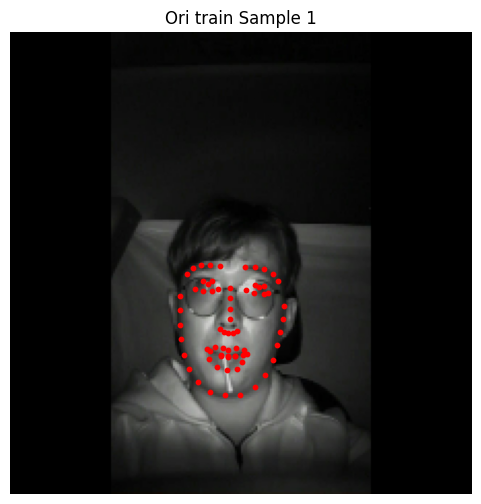

(16, 224, 224, 3) (16, 140)


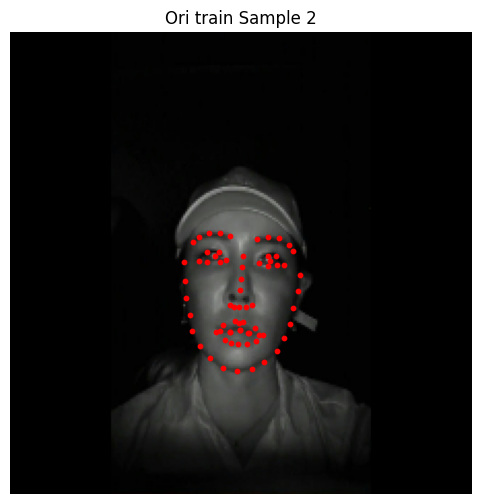

(16, 224, 224, 3) (16, 140)


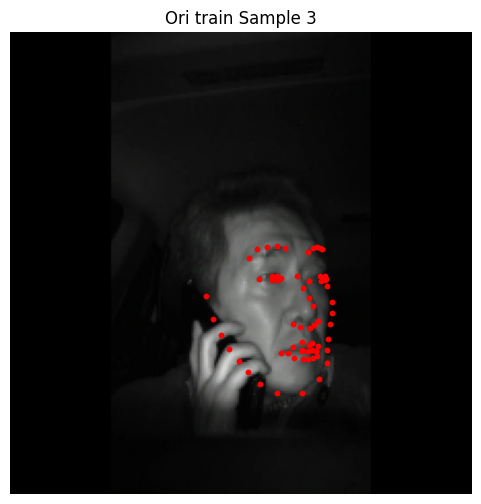

(16, 224, 224, 3) (16, 140)


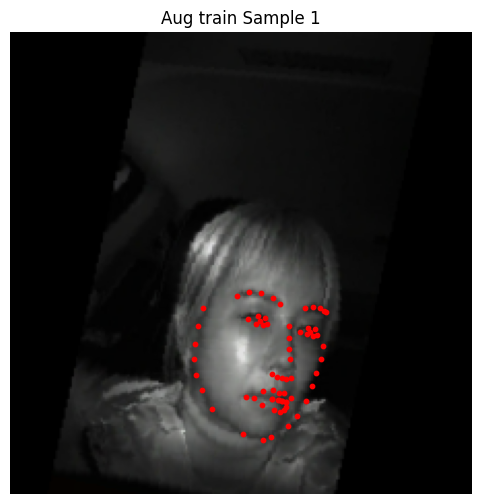

(16, 224, 224, 3) (16, 140)


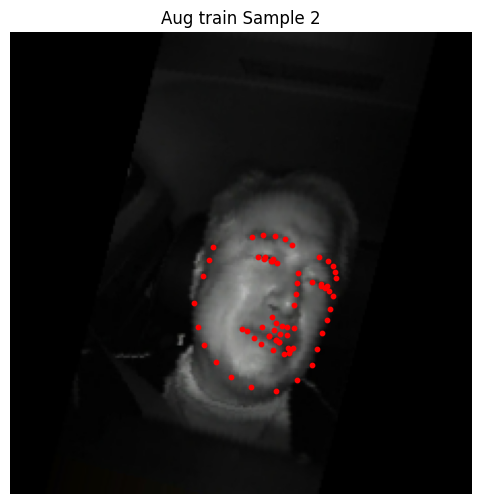

(16, 224, 224, 3) (16, 140)


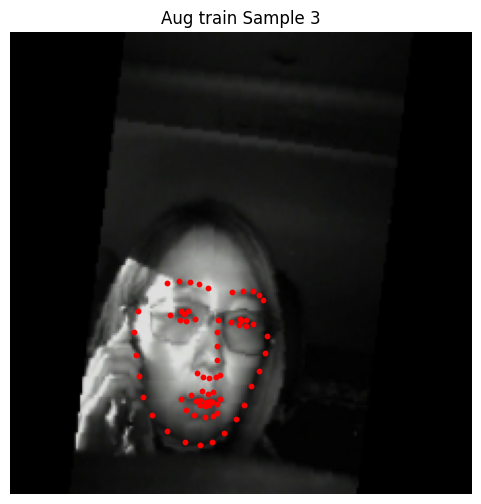

(16, 224, 224, 3) (16, 140)


In [10]:
for batch in original_train_dataset.take(1):
    images, keypoints = batch
    for i in range(3):  # 첫 3개 샘플 시각화
        visualize_sample(images[i], keypoints[i], title=f"Ori train Sample {i+1}")
        print (images.shape, keypoints.shape)
        
for batch in augmented_train_dataset.take(1):
    images, keypoints = batch
    for i in range(3):  # 첫 3개 샘플 시각화
        visualize_sample(images[i], keypoints[i], title=f"Aug train Sample {i+1}")
        print (images.shape, keypoints.shape)


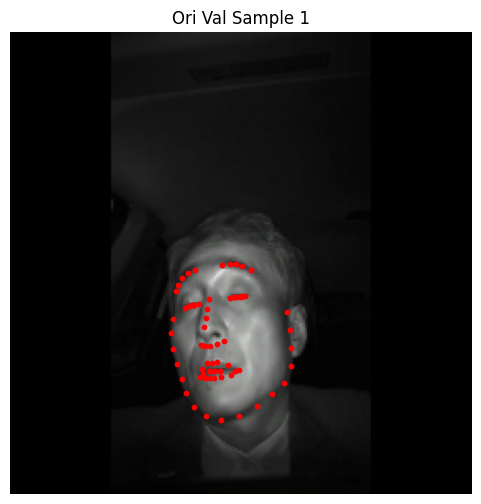

(16, 224, 224, 3) (16, 140)


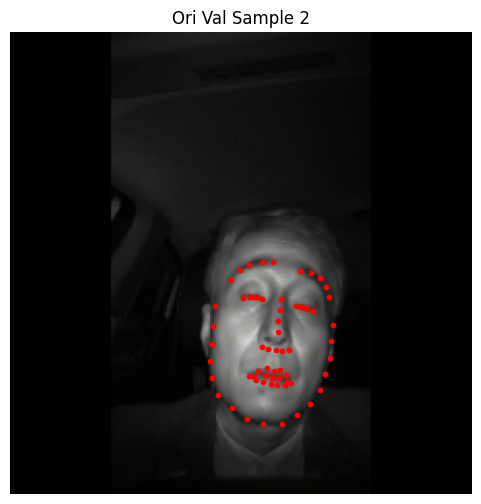

(16, 224, 224, 3) (16, 140)


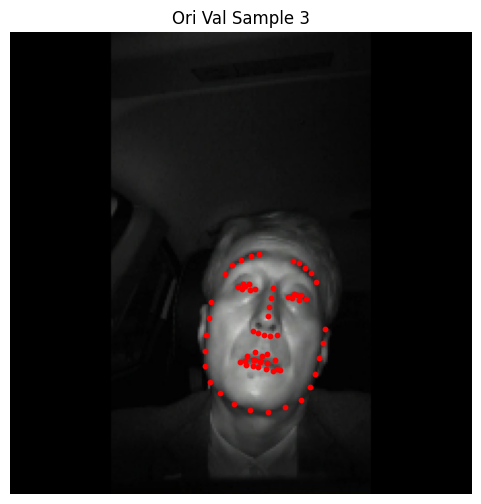

(16, 224, 224, 3) (16, 140)


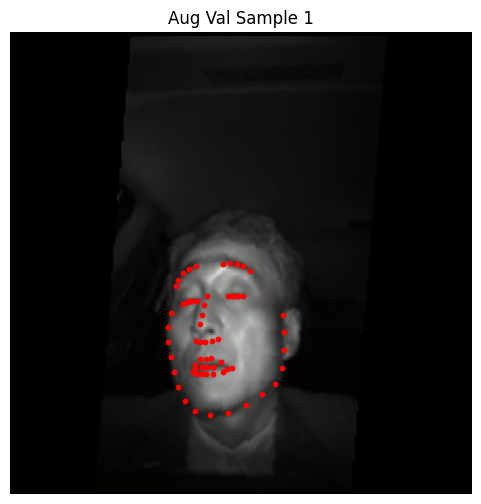

(16, 224, 224, 3) (16, 140)


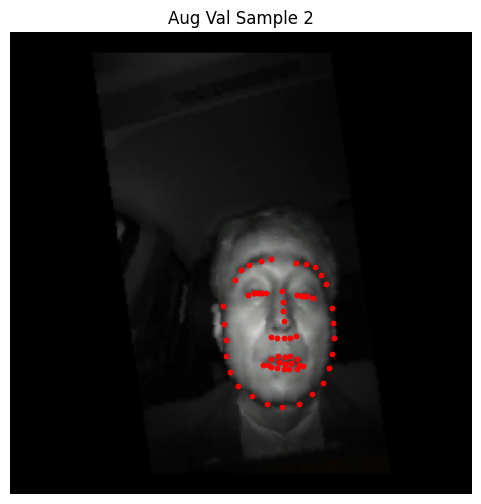

(16, 224, 224, 3) (16, 140)


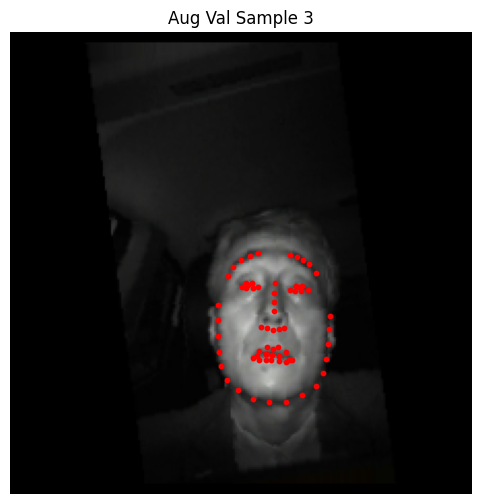

(16, 224, 224, 3) (16, 140)


In [6]:
for batch in original_val_dataset.take(1):
    images, keypoints = batch
    for i in range(3):  # 첫 3개 샘플 시각화
        visualize_sample(images[i], keypoints[i], title=f"Ori Val Sample {i+1}")
        print (images.shape, keypoints.shape)
        
for batch in augmented_val_dataset.take(1):
    images, keypoints = batch
    for i in range(3):  # 첫 3개 샘플 시각화
        visualize_sample(images[i], keypoints[i], title=f"Aug Val Sample {i+1}")
        print (images.shape, keypoints.shape)


In [7]:
# **전체 데이터셋 크기 확인**
def count_total_images(dataset):
    total = 0
    for batch in dataset:
        images, keypoints = batch
        total += images.shape[0]
    return total

train_total = count_total_images(train_dataset)
val_total = count_total_images(val_dataset)

print(f"\n훈련 데이터셋 전체 이미지 수: {train_total}")
print(f"검증 데이터셋 전체 이미지 수: {val_total}")


훈련 데이터셋 전체 이미지 수: 82080
검증 데이터셋 전체 이미지 수: 10880


# 모델학습

In [54]:
import keras
from keras import layers

# 1. 키포인트 수
NUM_KEYPOINTS = 70

# 2. 분산 전략 설정
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # 입력 레이어 정의
    inputs = layers.Input(shape=(224, 224, 3))
    x = preprocess_input(inputs)

    # 백본 모델 로드 (pre-trained MobileNetV3Large)
    base_model = MobileNetV3Large(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = True  # 백본 모델을 학습하도록 설정

    x = base_model(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)

    # 출력 레이어: 70개의 키포인트, 각 키포인트에 대해 x, y 좌표 (총 140개 출력)
    # 타겟 값이 [0, 1] 범위로 정규화되었다면 sigmoid 활성화 함수 사용
    x = layers.Dense(NUM_KEYPOINTS * 2, activation='sigmoid', dtype='float32')(x)

    # 모델 정의
    model = keras.Model(inputs=inputs, outputs=x)

    # 모델 컴파일
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# 모델 요약 출력
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d_3  (None, 960)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 960)               0         
                                                            

In [11]:
import keras
from keras import layers

# 1. 키포인트 수
NUM_KEYPOINTS = 70


# 입력 레이어 정의
inputs = layers.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)

# 백본 모델 로드 (pre-trained MobileNetV3Large)
base_model = MobileNetV3Large(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = True  # 백본 모델을 학습하도록 설정

x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)

# 출력 레이어: 70개의 키포인트, 각 키포인트에 대해 x, y 좌표 (총 140개 출력)
# 타겟 값이 [0, 1] 범위로 정규화되었다면 sigmoid 활성화 함수 사용
x = layers.Dense(NUM_KEYPOINTS * 2, activation='sigmoid', dtype='float32')(x)

# 모델 정의
model = keras.Model(inputs=inputs, outputs=x)

# 모델 컴파일
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# 모델 요약 출력
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 960)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 140)               134540    
                                                                 
Total params: 3130892 (11.94 MB)
Trainable params: 3106492 (1

In [65]:
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
import time

def lr_scheduler(epoch):
    if epoch < 100:
        return 0.001  # 첫 100 에포크 동안 학습률은 0.001
    else:
        return 0.0001  # 에포크 101부터 200까지 학습률은 0.0001

# 에포크 시간 측정을 위한 콜백 클래스 정의
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()
        
# 콜백 설정
checkpoint = ModelCheckpoint('v3l_adam_lr001_aug.h5', monitor='val_loss', save_best_only=True, verbose=1)
lr_scheduler_callback = LearningRateScheduler(lr_scheduler)
time_callback = TimeHistory()

# **모델 훈련**

EPOCHS = 200

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint, lr_scheduler_callback, time_callback]
)

Epoch 1/200
   5129/Unknown - 379s 68ms/step - loss: 2.6336e-04 - mae: 0.0110
Epoch 1: val_loss improved from inf to 0.01371, saving model to v3l_adam_lr001_aug.h5
5129/5129 [==============================] - 399s 72ms/step - loss: 2.6336e-04 - mae: 0.0110 - val_loss: 0.0137 - val_mae: 0.0882 - lr: 0.0010
Epoch 2/200
5129/5129 [==============================] - ETA: 0s - loss: 8.4346e-05 - mae: 0.0070
Epoch 2: val_loss did not improve from 0.01371
5129/5129 [==============================] - 369s 72ms/step - loss: 8.4346e-05 - mae: 0.0070 - val_loss: 0.2135 - val_mae: 0.4354 - lr: 0.0010
Epoch 3/200
5129/5129 [==============================] - ETA: 0s - loss: 6.4499e-05 - mae: 0.0060
Epoch 3: val_loss did not improve from 0.01371
5129/5129 [==============================] - 368s 72ms/step - loss: 6.4499e-05 - mae: 0.0060 - val_loss: 0.0222 - val_mae: 0.1241 - lr: 0.0010
Epoch 4/200
5129/5129 [==============================] - ETA: 0s - loss: 5.5266e-05 - mae: 0.0055
Epoch 4: val_loss i

In [6]:
# 분산 전략 설정: GPU 수에 따라 설정
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) >= 1:
    strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])
    print(f'사용 중인 디바이스 수: {strategy.num_replicas_in_sync}')
else:
    strategy = tf.distribute.MirroredStrategy()
    print(f'기본 전략 사용 중: {strategy.num_replicas_in_sync}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
사용 중인 디바이스 수: 1


In [7]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, CSVLogger
import time
from tensorflow.keras import layers, models

# 분산 전략 내에서 모델 정의 및 컴파일
with strategy.scope():
    # 3. 모델 로드
    model = tf.keras.models.load_model('v3l_adam_lr001_aug.h5')
    
    # 4. 모델 컴파일
    # 옵티마이저, 손실 함수, 평가 지표를 정의합니다.
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-7),
        loss='mse',
        metrics=['mae']
    )
    
    # 5. 콜백 설정
    checkpoint = ModelCheckpoint('v3l_rmsprop_aug.h5', monitor='val_loss', save_best_only=True, verbose=1)
    # reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1)
    csv_logger = CSVLogger('training_log.csv', append=True)
    
    # 6. 배치 사이즈 설정
    per_replica_batch_size = 16
    GLOBAL_BATCH_SIZE = per_replica_batch_size * strategy.num_replicas_in_sync
    
    # 7. 모델 훈련
    EPOCHS = 100
    
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=[checkpoint, csv_logger]
    )

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2024-11-11 12:26:59.514175: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-11-11 12:27:01.822968: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2444937f30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-11 12:27:01.823022: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-11-11 12:27:01.823029: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-11-11 12:27:01.823035: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): Tesla T4, Compute Capability 7.5
2024-11-11 12:27:01.828527: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-11 12:27:01.913162: I ./tensorflow/compiler/jit/device_compiler.h:186] Compi

   5129/Unknown - 348s 63ms/step - loss: 2.4223e-05 - mae: 0.0037

2024-11-11 12:32:36.292980: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14128093680476719441
2024-11-11 12:32:36.293043: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3599748849086884497
2024-11-11 12:32:36.293054: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17213454683747652397
2024-11-11 12:32:36.293064: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3098219419427222833
2024-11-11 12:32:36.293072: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4477678595282534742
2024-11-11 12:32:36.293082: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15627989484443189427
2024-11-11 12:32:36.293090: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv 


Epoch 1: val_loss improved from inf to 0.00004, saving model to v3l_rmsprop_aug.h5


2024-11-11 12:32:59.508991: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1046933909378912745
2024-11-11 12:32:59.509064: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7157483721661835418
2024-11-11 12:32:59.509076: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5198372437695494450
2024-11-11 12:32:59.509087: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11268707233738915607
2024-11-11 12:32:59.509098: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12475302286610702768
2024-11-11 12:32:59.509105: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1920869012389843460
2024-11-11 12:32:59.509115: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv i

5129/5129 [==============================] - 372s 68ms/step - loss: 2.4223e-05 - mae: 0.0037 - val_loss: 3.6136e-05 - val_mae: 0.0042
Epoch 2/100
5129/5129 [==============================] - ETA: 0s - loss: 2.4225e-05 - mae: 0.0037
Epoch 2: val_loss did not improve from 0.00004
5129/5129 [==============================] - 348s 68ms/step - loss: 2.4225e-05 - mae: 0.0037 - val_loss: 3.6146e-05 - val_mae: 0.0042
Epoch 3/100
5129/5129 [==============================] - ETA: 0s - loss: 2.4232e-05 - mae: 0.0037
Epoch 3: val_loss did not improve from 0.00004
5129/5129 [==============================] - 349s 68ms/step - loss: 2.4232e-05 - mae: 0.0037 - val_loss: 3.6353e-05 - val_mae: 0.0042
Epoch 4/100
5129/5129 [==============================] - ETA: 0s - loss: 2.4188e-05 - mae: 0.0037
Epoch 4: val_loss did not improve from 0.00004
5129/5129 [==============================] - 348s 68ms/step - loss: 2.4188e-05 - mae: 0.0037 - val_loss: 3.6187e-05 - val_mae: 0.0042
Epoch 5/100
5129/5129 [======

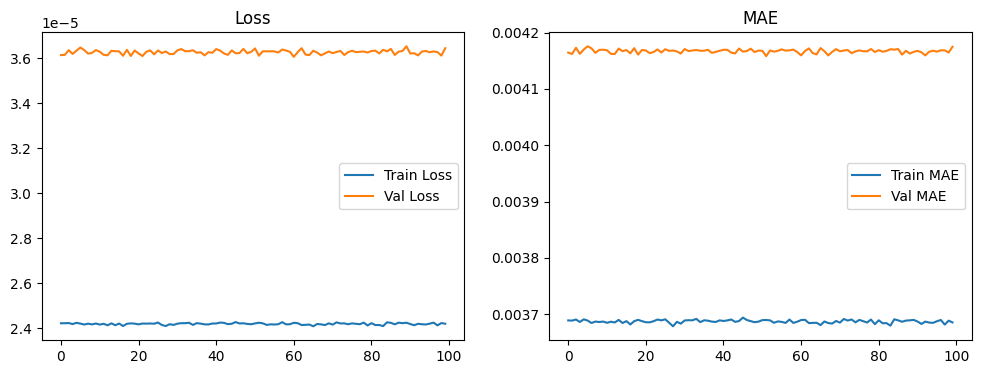

In [12]:
import matplotlib.pyplot as plt

# 훈련 손실 및 MAE 시각화
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

# MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.legend()
plt.title('MAE')

plt.show()

In [12]:
# 분산 전략 설정: GPU 수에 따라 설정
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) >= 1:
    strategy = tf.distribute.MirroredStrategy(devices=["/gpu:1"])
    print(f'사용 중인 디바이스 수: {strategy.num_replicas_in_sync}')
else:
    strategy = tf.distribute.MirroredStrategy()
    print(f'기본 전략 사용 중: {strategy.num_replicas_in_sync}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:1',)
사용 중인 디바이스 수: 1


In [13]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, CSVLogger
import time
from tensorflow.keras import layers, models

# 분산 전략 내에서 모델 정의 및 컴파일
with strategy.scope():
    # 3. 모델 로드
    model = tf.keras.models.load_model('v3l_adam_lr001_aug.h5')
    
    # 4. 모델 컴파일
    # 옵티마이저, 손실 함수, 평가 지표를 정의합니다.
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
        loss='mse',
        metrics=['mae']
    )
    
    # 5. 콜백 설정
    checkpoint = ModelCheckpoint('v3l_rmsprop_1e-3_aug.h5', monitor='val_loss', save_best_only=True, verbose=1)
    # reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1)
    csv_logger = CSVLogger('training_log_1e-3.csv', append=True)
    
    # 6. 배치 사이즈 설정
    per_replica_batch_size = 16
    GLOBAL_BATCH_SIZE = per_replica_batch_size * strategy.num_replicas_in_sync
    
    # 7. 모델 훈련
    EPOCHS = 100
    
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=[checkpoint, csv_logger]
    )

Epoch 1/100
   5129/Unknown - 386s 72ms/step - loss: 2.3509e-05 - mae: 0.0036

2024-11-12 03:06:12.721515: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2399025672313802949
2024-11-12 03:06:12.721629: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 589829778931829
2024-11-12 03:06:12.721641: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6371466010579080013
2024-11-12 03:06:12.721657: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5440673099413018330
2024-11-12 03:06:12.721668: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3303018622671464298
2024-11-12 03:06:12.721678: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4573434904599075046
2024-11-12 03:06:12.721687: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item ca


Epoch 1: val_loss improved from inf to 0.00004, saving model to v3l_rmsprop_1e-3_aug.h5


2024-11-12 03:06:35.893202: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16849968901504378152
2024-11-12 03:06:35.893454: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7643136445921035365
2024-11-12 03:06:35.893472: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9494535549931414122
2024-11-12 03:06:35.893483: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9955794503624587722
2024-11-12 03:06:35.893492: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8503832483661625614
2024-11-12 03:06:35.893499: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3117607608691412202
2024-11-12 03:06:35.893508: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv it

5129/5129 [==============================] - 411s 77ms/step - loss: 2.3509e-05 - mae: 0.0036 - val_loss: 3.6180e-05 - val_mae: 0.0042
Epoch 2/100
5129/5129 [==============================] - ETA: 0s - loss: 2.3492e-05 - mae: 0.0036
Epoch 2: val_loss improved from 0.00004 to 0.00004, saving model to v3l_rmsprop_1e-3_aug.h5
5129/5129 [==============================] - 396s 77ms/step - loss: 2.3492e-05 - mae: 0.0036 - val_loss: 3.5904e-05 - val_mae: 0.0041
Epoch 3/100
5129/5129 [==============================] - ETA: 0s - loss: 2.3488e-05 - mae: 0.0036
Epoch 3: val_loss did not improve from 0.00004
5129/5129 [==============================] - 397s 77ms/step - loss: 2.3488e-05 - mae: 0.0036 - val_loss: 3.6158e-05 - val_mae: 0.0042
Epoch 4/100
5129/5129 [==============================] - ETA: 0s - loss: 2.3377e-05 - mae: 0.0036
Epoch 4: val_loss did not improve from 0.00004
5129/5129 [==============================] - 396s 77ms/step - loss: 2.3377e-05 - mae: 0.0036 - val_loss: 3.6101e-05 - 

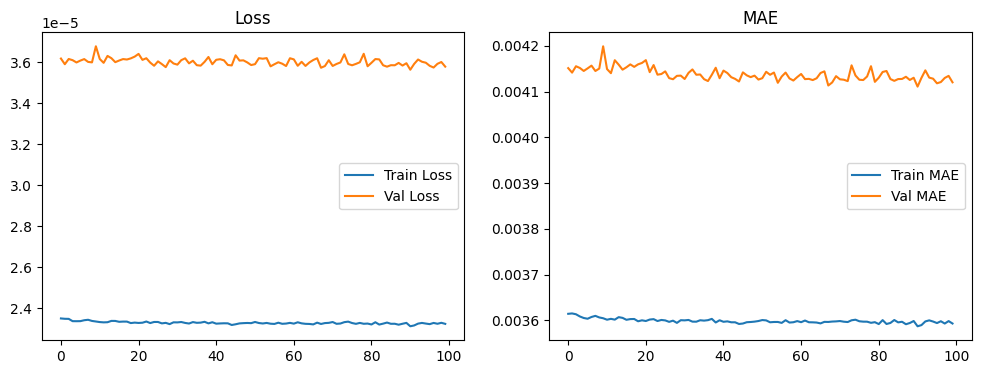

In [15]:
import matplotlib.pyplot as plt

# 훈련 손실 및 MAE 시각화
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

# MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.legend()
plt.title('MAE')

plt.show()

모델이 성공적으로 로드되었습니다.
1/1 [==============================] - 1s 1s/step
평균 제곱 오차(MSE): 27.7985
평균 절대 오차(MAE): 3.7361
정확도(Accuracy): 0.8000
정밀도(Precision): 1.0000
재현율(Recall): 0.8000
F1-스코어(F1-score): 0.8889


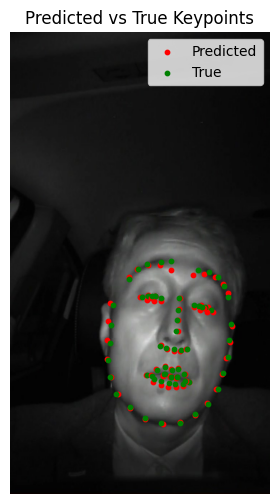

In [14]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd

def evaluate_single_image(model, image_path, image_dir, true_keypoints, target_size=224, threshold=10):
    """
    단일 이미지에 대해 모델의 예측을 수행하고, 평가 지표를 계산하며 시각화하는 함수.

    Parameters:
        model (tf.keras.Model): 사전 학습된 모델.
        image_path (str): 예측할 이미지의 경로.
        image_dir (str): 이미지가 저장된 디렉토리 경로.
        true_keypoints (np.ndarray): 실제 키포인트 좌표 (1차원 배열, 길이 140).
        target_size (int): 모델의 입력 이미지 크기.
        threshold (float): 키포인트를 올바르게 예측한 것으로 간주할 거리 임계값.
    """
    # 이미지 로드 및 전처리
    image_full_path = os.path.join(image_dir, image_path)
    image = cv2.imread(image_full_path)
    if image is None:
        print(f"이미지를 불러올 수 없습니다: {image_full_path}")
        return
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    orig_h, orig_w = image_rgb.shape[:2]

    # 종횡비 유지하며 리사이즈
    scale = min(target_size / orig_w, target_size / orig_h)
    new_w = int(orig_w * scale)
    new_h = int(orig_h * scale)
    image_resized = cv2.resize(image_rgb, (new_w, new_h))

    # 패딩 추가하여 타겟 사이즈 맞추기
    pad_w = target_size - new_w
    pad_h = target_size - new_h
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left
    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top

    image_padded = cv2.copyMakeBorder(
        image_resized, pad_top, pad_bottom, pad_left, pad_right,
        cv2.BORDER_CONSTANT, value=0
    )

    # 이미지 흑백 변환 및 3채널로 확장 (필요한 경우)
    image_gray = cv2.cvtColor(image_padded, cv2.COLOR_RGB2GRAY)
    image_input = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2RGB)

    # 정규화 및 배치 차원 추가
    input_image = image_input / 255.0
    input_image = np.expand_dims(input_image, axis=0).astype(np.float32)

    # 예측
    predicted_keypoints = model.predict(input_image)[0]

    # 모델 출력이 [0,1] 범위이므로, 이를 [0, target_size]로 변환
    predicted_keypoints = predicted_keypoints * target_size

    # 패딩 제거 및 원본 이미지 크기로 복원
    predicted_keypoints[::2] = (predicted_keypoints[::2] - pad_left) / scale
    predicted_keypoints[1::2] = (predicted_keypoints[1::2] - pad_top) / scale

    # 실제 키포인트와 예측 키포인트의 MSE 및 MAE 계산
    mse = mean_squared_error(true_keypoints, predicted_keypoints)
    mae = mean_absolute_error(true_keypoints, predicted_keypoints)

    print(f"평균 제곱 오차(MSE): {mse:.4f}")
    print(f"평균 절대 오차(MAE): {mae:.4f}")

    # 추가: Accuracy, Precision, Recall, F1-Score 계산
    # 키포인트를 (num_keypoints, 2) 형태로 재구성
    num_keypoints = len(true_keypoints) // 2
    true_keypoints_reshaped = true_keypoints.reshape(-1, 2)
    predicted_keypoints_reshaped = predicted_keypoints.reshape(-1, 2)

    # 각 키포인트의 유클리드 거리 계산
    distances = np.linalg.norm(true_keypoints_reshaped - predicted_keypoints_reshaped, axis=1)

    # 임계값을 기준으로 이진화
    y_true = np.ones(num_keypoints, dtype=int)  # 모든 키포인트는 검출되어야 함
    y_pred = (distances <= threshold).astype(int)  # 임계값 이하면 1, 아니면 0

    # 분류 지표 계산
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"정확도(Accuracy): {accuracy:.4f}")
    print(f"정밀도(Precision): {precision:.4f}")
    print(f"재현율(Recall): {recall:.4f}")
    print(f"F1-스코어(F1-score): {f1:.4f}")

    # 키포인트 시각화
    plt.figure(figsize=(10, 6))
    plt.imshow(image_rgb)
    
    for i in range(num_keypoints):
        x_pred, y_pred_point = predicted_keypoints_reshaped[i]
        x_true, y_true_point = true_keypoints_reshaped[i]
        
        # 예측 키포인트
        if 0 <= x_pred < orig_w and 0 <= y_pred_point < orig_h:
            plt.scatter(x_pred, y_pred_point, c='r', s=10, label='Predicted' if i == 0 else "")
        else:
            print(f"키포인트 {i}가 이미지 범위를 벗어났습니다: ({x_pred}, {y_pred_point})")
        
        # 실제 키포인트
        if 0 <= x_true < orig_w and 0 <= y_true_point < orig_h:
            plt.scatter(x_true, y_true_point, c='g', s=10, label='True' if i == 0 else "")
        else:
            print(f"실제 키포인트 {i}가 이미지 범위를 벗어났습니다: ({x_true}, {y_true_point})")
    
    plt.title('Predicted vs True Keypoints')
    plt.legend(['Predicted', 'True'])
    plt.axis('off')
    plt.show()

# 모델 로드 (예: 'model.h5' 경로에 저장된 모델)
model_path = 'model_h5/v3l_rmsprop_1e-3_aug.h5'
loaded_model = tf.keras.models.load_model(model_path)
print("모델이 성공적으로 로드되었습니다.")

# 데이터 로드 함수
def load_data(csv_file, image_dir):
    df = pd.read_csv(csv_file)
    image_paths = df['image_path'].tolist()
    keypoints = df.iloc[:, 1:].values.astype(np.float32)  # [x1, y1, x2, y2, ..., x70, y70]
    return image_paths, keypoints
    
# 단일 테스트 이미지 선택 (예: 첫 번째 이미지)
sample_image_path = val_image_paths[1]
sample_keypoints = val_keypoints[1]

# 평가 및 시각화 수행
evaluate_single_image(loaded_model, sample_image_path, val_image_dir, sample_keypoints, target_size=224)

# 예시: 테스트 데이터 로드
# test_csv_file = 'path_to_test_csv/test_annotations.csv'
# test_image_dir = 'path_to_test_images'
# test_image_paths, test_keypoints = load_data(test_csv_file, test_image_dir)

# 단일 테스트 이미지 선택 (예: 첫 번째 이미지)
# sample_image_path = test_image_paths[0]
# sample_keypoints = test_keypoints[0]

# 예시 실행
# evaluate_single_image(loaded_model, sample_image_path, test_image_dir, sample_keypoints, target_size=224)
